In [39]:
import copy
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import linalg as LA
from scipy.spatial.distance import cdist
global MAX
MAX = 100.0
#used for end condition
global Epsilon
Epsilon = 0.01


d = pd.read_excel('Comparisons - as given to MEC Students.xlsx',sheet_name='Final Data',header=None)
dz=d.iloc[2:, :]
df=np.array(dz)

In [40]:
def fcm(data, n_clusters=1, n_init=30, m=2, max_iter=300, tol=1e-16):

    min_cost = np.inf
    for iter_init in range(n_init):

        # Randomly initialize centers
        centers = data[np.random.choice(
            data.shape[0], size=n_clusters, replace=False
            ), :]

        # Compute initial distances
        # Zeros are replaced by eps to avoid division issues
        dist = np.fmax(
            cdist(centers, data, metric='sqeuclidean'),
            np.finfo(np.float64).eps
        )
        itr=0
        for iter1 in range(max_iter):
            
            # Compute memberships       
            u = (1 / dist) ** (1 / (m-1))
            um = (u / u.sum(axis=0))**m

            # Recompute centers
            prev_centers = centers
            centers = um.dot(data) / um.sum(axis=1)[:, None]

            dist = cdist(centers, data, metric='sqeuclidean')
            itr+=1
            if np.linalg.norm(centers - prev_centers) < tol:
                break

        # Compute cost
        cost = np.sum(um * dist)
        if cost < min_cost:
            min_cost = cost
            min_centers = centers
            mem = um.argmax(axis=0)

    return min_centers, mem,cost,itr




In [41]:

centers, mem ,cost,ite= fcm(df, n_clusters=2, n_init=30, m=2, max_iter=300, tol=1e-16)
print(len(mem))                

572


In [42]:
iterations=[]

for i in range(2,12):
    centers, mem ,cost,iteration= fcm(df, n_clusters=i, n_init=30, m=2, max_iter=300, tol=1e-16)
    iterations.append(iteration)
obj=[]

for i in range(2,12):
    centers, mem ,cost,iteration= fcm(df, n_clusters=i, n_init=30, m=2, max_iter=300, tol=1e-16)
    obj.append(cost)



KeyboardInterrupt: 

No handles with labels found to put in legend.


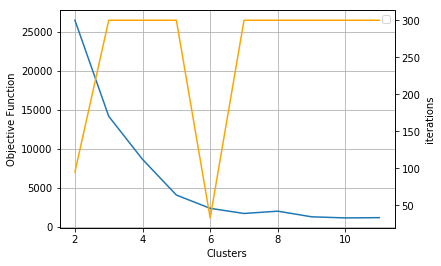

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(2,12), obj)

ax2 = ax.twinx()
ax2.plot(range(2,12), iterations, label='iterations',color='orange')
ax.legend()
ax.grid()
ax.set_xlabel("Clusters")
ax.set_ylabel('Objective Function')
ax2.set_ylabel('iterations')

plt.show()

In [17]:
centers, mem ,cost,iteration= fcm(df, n_clusters=6, n_init=30, m=2, max_iter=300, tol=1e-16)
colors=['r','b','g','y','c','m']

f=lambda x: colors[int(x)]

mem=list(map(f,mem))


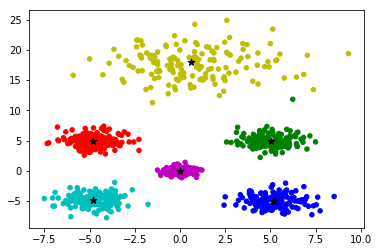

In [18]:
plt.scatter(df[:,0],df[:,1],c=mem,s=20)

plt.scatter(centers[:,0],centers[:,1],c='black',s=50,marker='*')


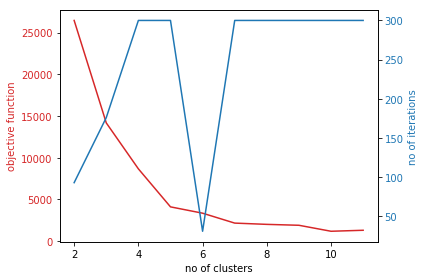

In [19]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('no of clusters')
ax1.set_ylabel('objective function', color=color)
ax1.plot(range(2,12),obj, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('no of iterations', color=color)  # we already handled the x-label with ax1
ax2.plot(range(2,12), iterations, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [18]:
def part_mat(df,cluster):
    U=np.random.randint(2,size=(len(df),cluster))
    return U
def cluster_mean(Z,U,m):
    N = len(Z)
    n = len(Z[0])
    c = len(U[0])
    v = np.zeros((c,n))
    temp_u = np.zeros((N,c))
    for i in range(0,N):
        for j in range(0,c):
            temp_u[i][j] =((U[i][j])**m)
    for j in range(0,c):
        for k in range(0,n):
            numr = 0
            deno = 0
            for i in range(0,N):
                numr = numr + temp_u[i][j] * Z[i][k]
                deno = deno + temp_u[i][j]
            v[j][k] = numr/deno
    return v

def distance(v,Z):
    N = len(Z)
    n = len(Z[0])
    c = len(v)
    D = np.zeros((N,c))
    
    for i in range(0,N):
        for j in range(0,c):
            temp1 = np.subtract(Z[i],v[j])
            
            temp2 = np.transpose(temp1)
            temp3 = np.matmul(temp2,temp1)
            
            
            D[i][j] = math.sqrt(temp3)
    
    return D
def update(D,a,b,m):
    p = 2.0/(m-1)
    N = len(D)
    c = len(D[0])
    new_U = np.zeros((a,b))
    for i in range(0,N):
        temp1 = 1
        for j in range(0,c):
            if (D[i][j] <= 0):
                temp1 = 0
                break
        if (temp1 == 1):
            for j in range(0,c):
                temp2 = 0
                for k in range(0,c):
                    x = float(D[i][j])/D[i][k]
                    temp2 = temp2 + (x**p)
                new_U[i][j] = 1.0/temp2
        else:
            for j in range(0,c):
                if (D[i][k] == 0):
                    new_U[i][j] = 1
                else:
                    new_U[i][j] = 0
    return new_U


def j(Z,v,U,m):
    c = len(v)
    N = len(Z)
    cost = 0
    for i in range(0,N):
        for j in range(0,c):
            temp1 = np.subtract(Z[i],v[j])
            temp2 = np.linalg.norm(temp1)
            cost = cost + ((temp2**2) * ((U[i][j])**m))
    return cost
def fuzzy_c(Z,cluster,m,e):
    U=part_mat(Z,cluster)
    kq=0
    
    while(True):
        U_old=copy.deepcopy(U)
        v=cluster_mean(Z,U,m)
        dis=distance(v,Z)
        U=update(dis,len(U),len(U[0]),m)
        
        kq+=1
        
        if(LA.norm(np.subtract(U,U_old))<e):
            cost=j(Z,v,U,m)
            
            break
    return U,kq,cost

In [20]:
m=2
e=0.001
iters=[]
costs=[]
for i in range(2,11):
    U,ite,cost=fuzzy_c(df,i,m,e)
    iters.append(ite)
    costs.append(cost)

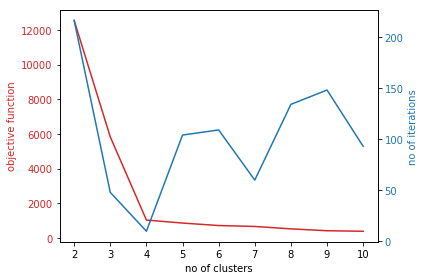

In [21]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('no of clusters')
ax1.set_ylabel('objective function', color=color)
ax1.plot(range(2,11),costs, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('no of iterations', color=color)  # we already handled the x-label with ax1
ax2.plot(range(2,11), iters, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [31]:
fuzzy_c(df,4,m,e)

(array([[0.02142189, 0.01129116, 0.94524639, 0.02204055],
        [0.05063167, 0.0196494 , 0.90075208, 0.02896684],
        [0.01837616, 0.00790719, 0.96085596, 0.0128607 ],
        ...,
        [0.26283745, 0.27046637, 0.24130903, 0.22538715],
        [0.30229521, 0.22908646, 0.27444125, 0.19417708],
        [0.41529383, 0.11796192, 0.36186898, 0.10487527]]),
 26,
 5460.118135107892)

In [1]:
mem

NameError: name 'mem' is not defined